## Noisy RGB pixel only, Fit residual, L1 loss, 1/8 U-Net bottleneck

In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


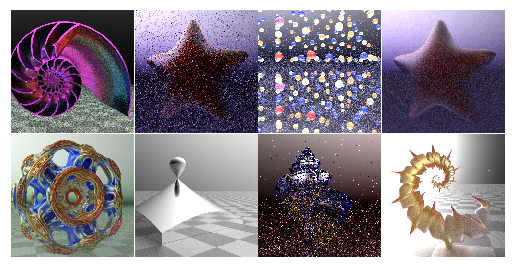

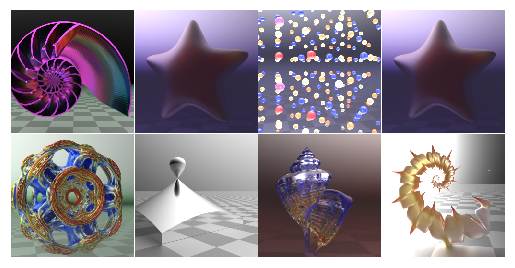

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
# plot_imgs(a[:, 0:3])
# plot_imgs(a[:, 3:6]*0.5+0.5)
# plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 16
        n1 = 24
        n2 = 32
        n3 = 48
        self.econv0a = conv3(3, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1 = conv3(n0, n1) # 1/2
        self.econv2 = conv3(n1, n2) # 1/4
        self.mconv1 = conv3(n2, n3) # 1/8
        self.mconv2 = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv3(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv3(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv3(n0+n0, n0) # 1
        self.dconv0 = conv3(n0, 3) # 1

    def forward(self, input):
        e0 = self.econv0b(relu(self.econv0a(input))) # 1
        e1 = self.econv1(pool(e0)) # 1/2
        e2 = self.econv2(pool(e1)) # 1/4
        m1 = self.mconv1(pool(e2)) # 1/8
        m2 = self.mconv2(relu(m1)) # 1/8
        d2 = relu(self.dconv2a(relu(m2))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        d0 = relu(self.dconv0b(concat(d0, e0))) # 1
        return self.dconv0(d0)


model = Model().to(device)
print(model)

Model(
  (econv0a): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv1): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(48, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv1a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv0a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv0b): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv0): Conv2d(16, 

128 0.01968671940267086
256 0.020369350910186768
384 0.01884300261735916
512 0.01067950390279293
640 0.017543975263834
768 0.03655456006526947
896 0.009826142340898514
1024 0.022069167345762253
1152 0.0071589648723602295
1280 0.019846400246024132
1408 0.011344167403876781
1536 0.01077786274254322
1664 0.015562174841761589
1792 0.012511084787547588
1920 0.013349780812859535
2048 0.007739255204796791
2176 0.015010720118880272
2304 0.012031052261590958
2432 0.011161806993186474
2560 0.012610755860805511
2688 0.015375044196844101
2816 0.011083505116403103
2944 0.007391039282083511
3072 0.023824110627174377
3200 0.014413217082619667
3328 0.009771955199539661
3456 0.019805027171969414
3584 0.008230533450841904
3712 0.017420977354049683
3840 0.007659764960408211
3968 0.015262184664607048
4096 0.0038767193909734488


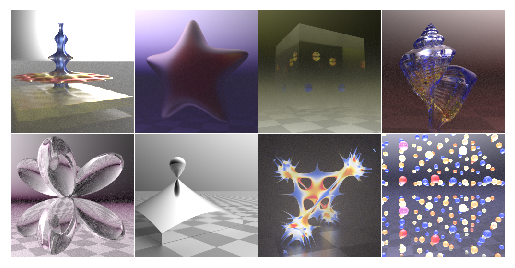

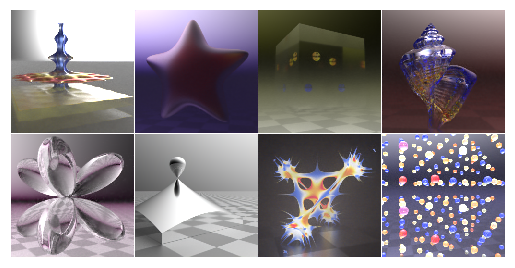

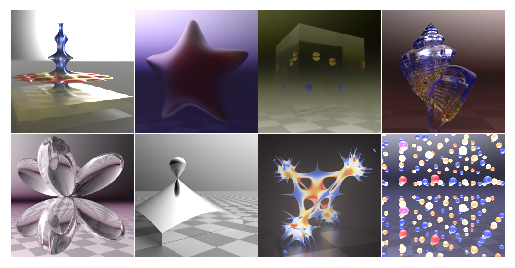

4224 0.025363687425851822
4352 0.00719296932220459
4480 0.013657500967383385
4608 0.01418319158256054
4736 0.010405756533145905
4864 0.016138866543769836
4992 0.0056759268045425415
5120 0.01188649982213974
5248 0.007908616214990616
5376 0.009829094633460045
5504 0.011108665727078915
5632 0.022620439529418945
5760 0.012696892023086548
5888 0.005472475662827492
6016 0.019922738894820213
6144 0.00875239446759224
6272 0.01360665075480938
6400 0.009834815748035908
6528 0.0037858746945858
6656 0.012448090128600597
6784 0.005640027113258839
6912 0.006277166306972504
7040 0.008548365905880928
7168 0.015246599912643433
7296 0.00411738408729434
7424 0.008909001015126705
7552 0.0075066788122057915
7680 0.008633672259747982
7808 0.009003778919577599
7936 0.016292676329612732
8064 0.005376167129725218
8192 0.009729009121656418


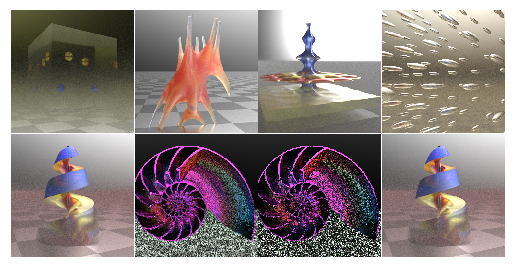

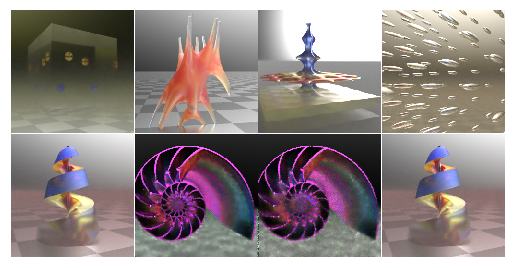

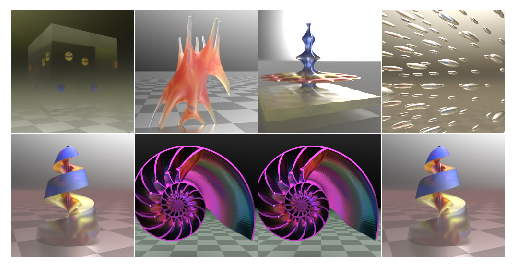

8320 0.011653119698166847
8448 0.01366172544658184
8576 0.01413350086659193
8704 0.004906655754894018
8832 0.013693911954760551
8960 0.007563370745629072
9088 0.00804123654961586
9216 0.011118571273982525
9344 0.01445026509463787
9472 0.00600206246599555
9600 0.018593013286590576
9728 0.00968828983604908
9856 0.014400236308574677
9984 0.014833505265414715
10112 0.019845370203256607
10240 0.005823349114507437
10368 0.006642790045589209
10496 0.01330218743532896
10624 0.006130596157163382
10752 0.011585261672735214
10880 0.015245508402585983
11008 0.0058651152066886425
11136 0.004080535843968391
11264 0.006774828769266605
11392 0.009906071238219738
11520 0.014286968857049942
11648 0.01059836894273758
11776 0.011708150617778301
11904 0.008401675149798393
12032 0.009405567310750484
12160 0.010263567790389061
12288 0.01488617341965437


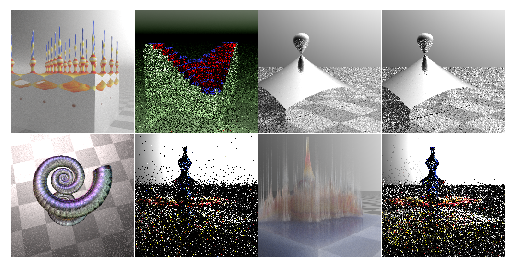

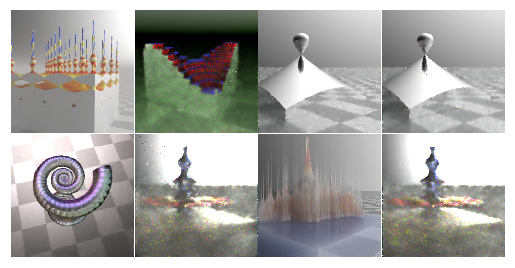

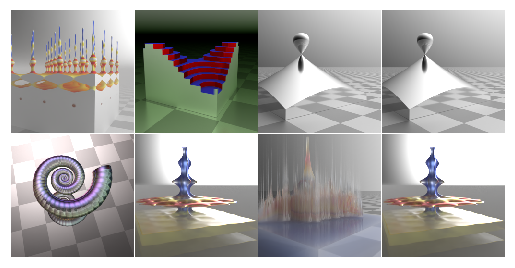

12416 0.019157057628035545
12544 0.006160118617117405
12672 0.004893365316092968
12800 0.012916138395667076
12928 0.011242700740695
13056 0.009870837442576885
13184 0.006894770078361034
13312 0.011234356090426445
13440 0.009193811565637589
13568 0.009103515185415745
13696 0.0072506144642829895
13824 0.01946084201335907
13952 0.005230400245636702
14080 0.010202575474977493
14208 0.01308739185333252
14336 0.006499513052403927
14464 0.010130554437637329
14592 0.022956496104598045
14720 0.0033427707385271788
14848 0.008807357400655746
14976 0.00617102300748229
15104 0.010847779922187328
15232 0.015599137172102928
15360 0.004394100978970528
15488 0.012010316364467144
15616 0.008134325966238976
15744 0.004422707483172417
15872 0.009496632032096386
16000 0.00697589386254549
16128 0.006154569797217846
16256 0.00879749096930027
16384 0.010171324014663696


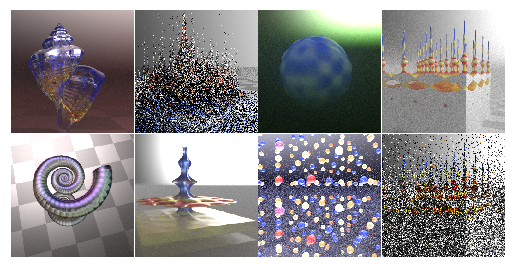

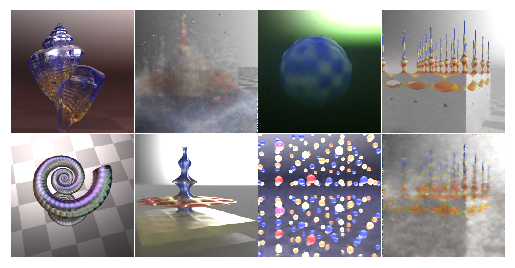

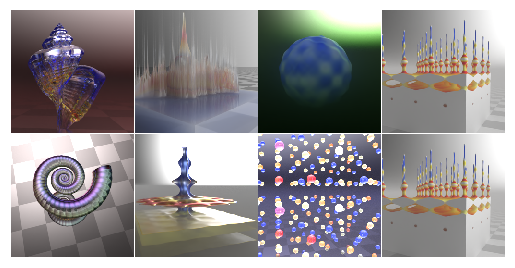

16512 0.008241992443799973
16640 0.010976320132613182
16768 0.012633852660655975
16896 0.012517204508185387
17024 0.011159785091876984
17152 0.006643038243055344
17280 0.011947195045650005
17408 0.006958222948014736
17536 0.0042526936158537865
17664 0.011840848252177238
17792 0.01566261798143387
17920 0.008294322527945042
18048 0.0034173186868429184
18176 0.009005030617117882
18304 0.009309237822890282
18432 0.005052677821367979
18560 0.010249324142932892
18688 0.0071516335010528564
18816 0.008733807131648064
18944 0.0060594696551561356
19072 0.010871856473386288
19200 0.00950464978814125
19328 0.020938461646437645
19456 0.007144076284021139
19584 0.015613403171300888
19712 0.005757815204560757
19840 0.0043691289611160755
19968 0.00836186483502388
20096 0.010553943924605846
20224 0.005388015415519476
20352 0.009464425966143608
20480 0.03626757487654686


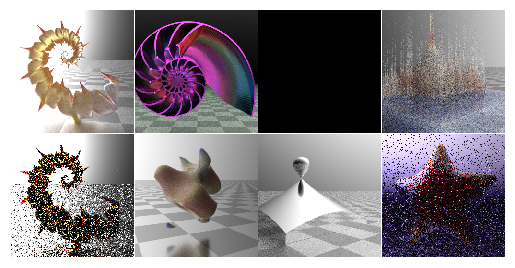

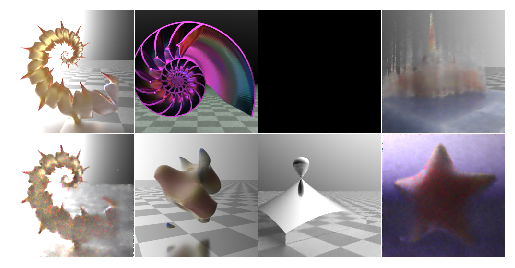

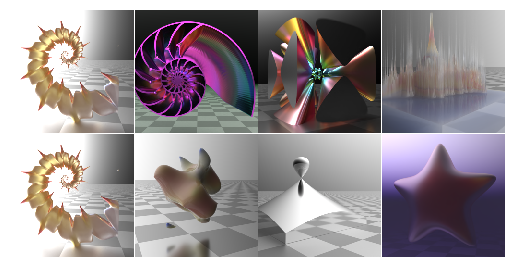

20608 0.009485564194619656
20736 0.00862865149974823
20864 0.009287911467254162
20992 0.01530949305742979
21120 0.007657747715711594
21248 0.007990114390850067
21376 0.005121169611811638
21504 0.009162794798612595
21632 0.012331774458289146
21760 0.009865336120128632
21888 0.015383767895400524
22016 0.004135536029934883
22144 0.008886939845979214
22272 0.011455634608864784
22400 0.008376501500606537
22528 0.006521254312247038
22656 0.008327102288603783
22784 0.004223311319947243
22912 0.013102772645652294
23040 0.0033959555439651012
23168 0.004408750683069229
23296 0.003443259745836258
23424 0.012677913531661034
23552 0.015478959307074547
23680 0.009788434021174908
23808 0.01242110412567854
23936 0.011151542887091637
24064 0.011556903831660748
24192 0.0052865068428218365
24320 0.011904045939445496
24448 0.009822608903050423
24576 0.00659897830337286


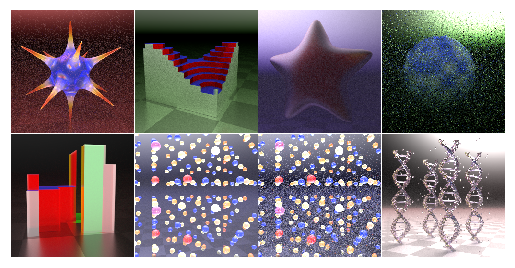

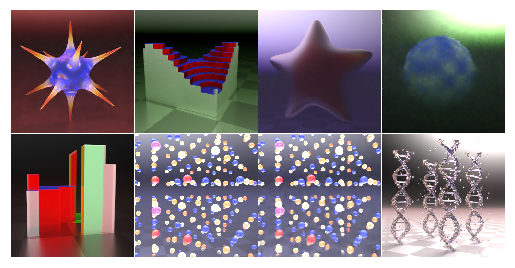

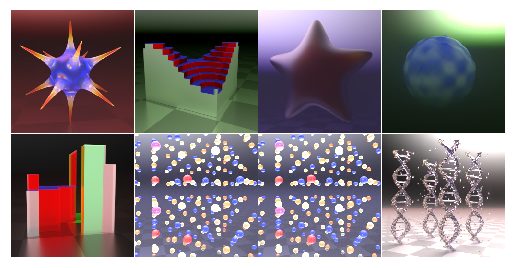

24704 0.008387051522731781
24832 0.006134937517344952
24960 0.006663764826953411
25088 0.002521091140806675
25216 0.008499081246554852
25344 0.005476584192365408
25472 0.008982758037745953
25600 0.009210215881466866
25728 0.011404077522456646
25856 0.010111628100275993
25984 0.0050959233194589615
26112 0.006020674016326666
26240 0.003647180972620845
26368 0.016375478357076645
26496 0.006354206707328558
26624 0.007935704663395882
26752 0.008466960862278938
26880 0.00469139963388443
27008 0.012858407571911812
27136 0.007959553971886635
27264 0.004360325168818235
27392 0.011476176790893078
27520 0.008451726287603378
27648 0.003294464899227023
27776 0.006248213350772858
27904 0.0069752708077430725
28032 0.007946877740323544
28160 0.012101268395781517
28288 0.012012319639325142
28416 0.008155230432748795
28544 0.006869498640298843
28672 0.005733782425522804


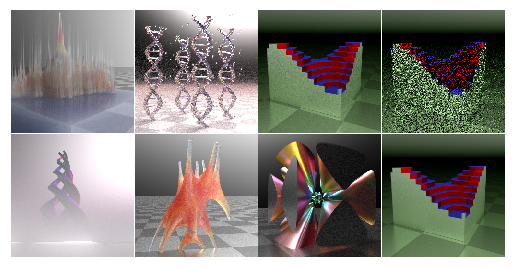

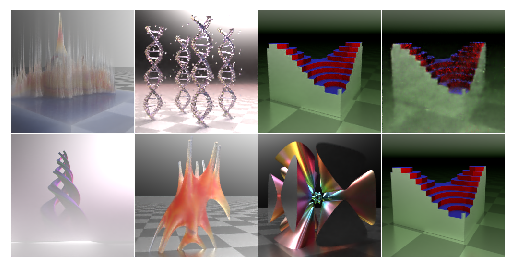

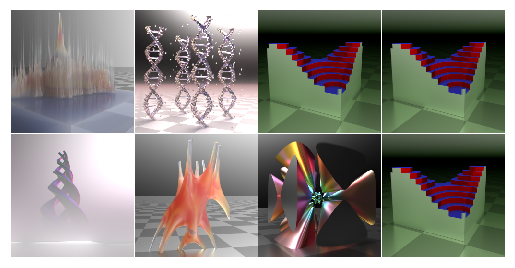

28800 0.004924479406327009
28928 0.006525828968733549
29056 0.010140610858798027
29184 0.004789678379893303
29312 0.010828650556504726
29440 0.006701494567096233
29568 0.013471748679876328
29696 0.004298300947993994
29824 0.003990299999713898
29952 0.007284889928996563
30080 0.014455543830990791
30208 0.005585664417594671
30336 0.0044763158075511456
30464 0.006824254058301449
30592 0.009118491783738136
30720 0.005988163407891989
30848 0.007317294832319021
30976 0.00597437284886837
31104 0.009639330208301544
31232 0.006536621600389481
31360 0.0058580078184604645
31488 0.00838320329785347
31616 0.008630734868347645
31744 0.008193782530725002
31872 0.012168539687991142
32000 0.004891089629381895
32128 0.008273613639175892
32256 0.010278035886585712
32384 0.009449822828173637
32512 0.008702346123754978
32640 0.010266939178109169
32768 0.0062689571641385555


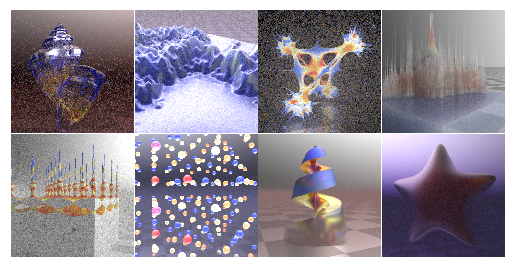

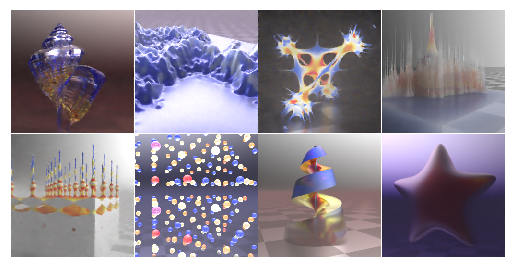

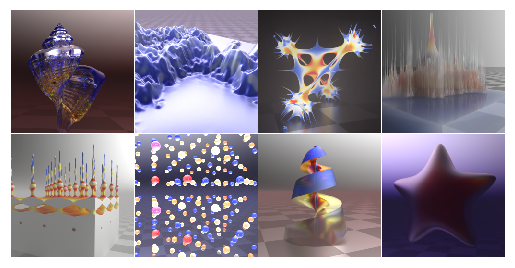

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
    # lr = 0.00001
)

def lossfun(output, reference):
    return torch.mean(torch.abs(output-reference))

model_params = torch.cat([x.view(-1) for x in model.parameters()])

batch_count = 0
for epoch in range(2):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        optimizer.zero_grad()
        output = model(x)
        torch.mean(torch.abs(output))
        loss = lossfun(output, y-x)
        # regl1 = 0.1 * torch.mean(torch.abs(model_params))
        # regl2 = 0.1 * torch.mean(torch.abs(model_params))
        # (loss+regl1+regl2).backward()
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 128 == 0:
            print(batch_count, loss.item())
        if batch_count % 4096 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp((output+x).detach())-1)
            plot_imgs(torch.exp(y)-1)


In [6]:
torch.save(model, "model3c.pth")